<a href="https://colab.research.google.com/github/jjmcfadyen/escape-game/blob/pythonSim/EscapeGame.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulating behaviour in an escape game

In [ ]:
import numpy as np
import pandas as pd
import math
import random
import warnings
from copy import copy
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.rcParams['figure.figsize'] = [10, 5]

## The Environment

The environment will have:
*   A transition matrix (which you need to define manually)
*   The current position of the exits, goal state, and predator (these are empty by default)

The environment can:
*   Show you a map using `showgrid`
*   Set the position of the agent, predator, and exits using `setpos`





In [ ]:
class Environment:

  # Initiate a 9-state grid world
  def __init__(self):

    # Set up grid
    self.grid         = np.empty((3,3)) # 3 x 3 matrix
    self.nStates      = np.prod(self.grid.shape)
    self.coords       = np.indices(self.grid.shape).reshape(2,self.nStates)

    self.coords       = np.flipud(self.coords) # swap x and y axes for plotting purposes
    self.coords[1,:]  = np.flip(self.coords[1,:]) # invert y axis so that states 1, 2, 3, etc. are at the top of the plot

    self.T      = np.zeros((self.nStates,self.nStates)) # transition matrix
    self.T[0,1] = 1 # state 1 to state 2
    self.T[0,3] = 1 # state 1 to state 4
    self.T[1,0] = 1 # state 2 to state 1
    self.T[1,4] = 1 # state 2 to state 5
    self.T[1,2] = 1 # state 2 to state 3
    self.T[2,1] = 1 # state 3 to state 2
    self.T[2,5] = 1 # state 3 to state 6
    self.T[3,0] = 1 # state 4 to state 1
    self.T[3,6] = 1 # state 4 to state 7
    self.T[4,1] = 1 # state 5 to state 2
    self.T[4,7] = 1 # state 5 to state 8
    self.T[5,8] = 1 # state 6 to state 9
    self.T[6,7] = 1 # state 7 to state 8
    self.T[6,3] = 1 # state 7 to state 4
    self.T[7,8] = 1 # state 8 to state 9
    self.T[7,4] = 1 # state 8 to state 5
    self.T[8,5] = 1 # state 9 to state 6
    self.T[8,7] = 1 # state 9 to state 8

    # Set up defaults
    self.agentpos     = None
    self.predatorpos  = None
    self.exits        = None
    self.goal         = None
    self.setpos()

  def setpos(self,agent=None,predator=None,exits=None,goal=None):

    # assumes the input is a state number starting from 1, and converts this to starting from 0
    if agent is not None:
      self.agentpos     = agent-1
    if predator is not None:
      self.predatorpos  = predator-1
    if exits is not None:
      self.exits        = [x - 1 for x in exits]
    if goal is not None:
      self.goal         = goal-1


## The agent

By default, the agent is a simple Q learner. 

### Q Learner
The agent can navigate the environment by selecting which state to go to next. Thus, there are as many actions as there are states. Successful navigation requires selecting states in the correct order (i.e., selecting states that transition to each other). For a model-free learner to successfully transition without any knowledge of the state space, the chances of selecting a valid action sequence is 1 in 6561 (~0.02% chance). Thus, we restricted action selection to only valid transitions.

### Successor representation


### Model-based

In [ ]:
class Agent:

  # ------------------------------------------------------------------------------------------------------
  # Initiate agent with specific model & parameters
  # ------------------------------------------------------------------------------------------------------
  def __init__(self,model="qlearner",params={"alpha": 0.5, "gamma": 1, "epsilon": 0.05},speed=1):

    # Set defaults
    self.status = "ready"
    self.model = model

    self.plan = None
    self.points = None

    # Set up model-specific variables
    if model=="qlearner":
      
      # set default parameters
      self.alpha = 0.5
      self.gamma = 1
      self.epsilon = 0.05

      # replace defaults with input
      if "alpha" in params:
        self.alpha = params["alpha"]

      if "gamma" in params:
        self.gamma = params["gamma"]

      if "epsilon" in params:
        self.epsilon = params["epsilon"]

      # create empty tables
      self.Q = None
      self.V = None
      self.R = None

    # Set agent move speed
    self.speed = speed

  # ----------------------------------------------------------------------------------------------------------------
  # Have the agent check the environment and update it according to the "play" rules (e.g., value of rewards, etc.)
  # ----------------------------------------------------------------------------------------------------------------
  def checkEnv(self,play):
    
    # check current position
    self.pos = play.env.agentpos

    # get list of possible actions
    self.actions = [i for i in range(play.env.nStates)]

    # initialise tables for Q learner, if empty
    if self.model=="qlearner":

      if self.Q is None:
        self.Q = np.zeros((play.env.nStates,play.env.nStates))

      if self.V is None:
        self.V = np.zeros(play.env.nStates)

      if self.R is None:

        self.R = np.zeros((play.env.nStates,play.env.nStates))

        # if there is no "goal" state, the exits are rewarded
        if play.env.goal is None:
          exits = play.env.exits
          for exit in exits:
            idx = np.where(play.env.T[:,exit]==1)
            self.R[idx,exit] = play.exitReward
          self.terminals = exits
        else: # otherwise, if there IS a goal state, this is the rewarded state
          goal = play.env.goal
          idx = np.where(play.env.T[:,goal]==1)
          self.R[idx[0],goal] = play.goalReward
          self.terminals = goal

        # take note of predator, if present
        if play.env.predatorpos is not None:
          predator = play.env.predatorpos
          idx = np.where(play.env.T[:,predator]==1)
          self.R[idx[0],goal] = play.predatorPenalty
          self.terminals = predator

  # ----------------------------------------------------------------------------------------------------------------
  # Decide which actions to take
  # ----------------------------------------------------------------------------------------------------------------
  def makePlan(self,play):
  
    if self.model=="qlearner":
      
      plan = [self.pos] # plan starts from current location
      for step in range(play.nSteps):

        # only select actions that have possible transitions, and aren't already in plan
        laststep = plan[len(plan)-1]
        reachable = np.array(np.where(play.env.T[laststep,:]==1)[0])
        actions = np.setdiff1d(reachable,plan) # only select reachable states that aren't in plan

        # choose an action either randomly (epsilon parameter) or according to Q table
        if random.uniform(0, 1) < self.epsilon:
          choice = np.random.choice(actions,1).astype(int)
        else:
          validQ = self.Q[self.pos,actions]
          maxidx = actions[np.argwhere(validQ == np.amax(validQ))].flatten()
          choice = np.random.choice(maxidx,1)

        plan = np.append(plan,choice.astype(int))

      self.plan = plan.astype(int)
      print("Planned action sequence = ", [x + 1 for x in self.plan])

  # ----------------------------------------------------------------------------------------------------------------
  # Execute action sequence and log time
  # ----------------------------------------------------------------------------------------------------------------
  def executePlan(self,play):

    trajectory  = []
    timestamp   = []
    reward      = 0
    outcome     = None

    currentPos  = self.plan[0]
    step        = 0
    moving      = True
    while moving:
      
      step    = step+1
      action  = self.plan[step]

      # check if chosen state (action) can be transitioned to from current position
      validTransition = play.env.T[currentPos,action]

      if validTransition:

        nextState   = action # here, the action IS the state that has been selected
        trajectory  = np.append(trajectory,nextState)
        timestamp   = np.append(timestamp,1/self.speed) # time (in "seconds") = distance (1 state) / agent speed (no. states per "second")

        # check for any reward
        reward = self.R[currentPos,action]

        if self.model=="qlearner":

          # update Q table
          oldQ = self.Q[currentPos,action]
          next_max = np.max(self.Q[nextState,:])
          newQ = (1 - self.alpha) * oldQ + self.alpha * (reward + self.gamma * next_max)
          self.Q[currentPos,action] = newQ

        # upate agent position
        currentPos = nextState

        # check if agent should terminate plan (reached a goal or exit)
        if currentPos == self.terminals:

          if play.env.goal is not None and currentPos == play.env.goal:
            print("Agent reached goal state")
            outcome = "goal reached"
            self.status = "working on goal"
            
          elif currentPos == play.env.exits:
            print("Agent reached exit")
            outcome = "escaped"

          self.pos = currentPos
          print("Agent pos = ",self.pos+1)
          moving = False

      else: # invalid transition...

        print("Agent's plan was invalid")

        outcome = "invalid plan"
        moving = False

      if step >= len(self.plan)-1:
        moving = False

    output = {"plan": self.plan,
              "trajectory": trajectory,
              "timestamp": timestamp,
              "reward": reward,
              "outcome": outcome}
    return(output)


## The predator

In [ ]:
class Predator:

  # -------------------------------------------------------------------------------
  # Initiate
  # -------------------------------------------------------------------------------
  def __init__(self,speed=1.3333,location=[],probability=[],waitdistribution="uniform",params=[0,2]):

    # determine how quickly (moves per "second") the predator can move from one state to the next
    self.speed = speed

    # randomly give predator a spawn location (in numbers starting from 1, not 0), given probability
    self.pos = None
    if location is not None:
      if probability is not None:
        if len(location) != len(probability):
          raise Exception("Number of locations must match probability vector")
        elif sum(probability) != 1:
          raise Exception("Probability vector must sum to 1!")
        else:
          self.pos = np.random.choice(location,1,False,probability).astype(int)[0] - 1
      elif len(location) > 1:
        raise Exception("More than one location given for predator without a probability vector!")
      else:
        self.pos = location-1

    # set probability of waiting before persuing agent
    self.waitdistribution = waitdistribution
    self.params = params

  # ---------------------------------------------------------------------------------------------
  # Have the predator follow the agent's trajectory (assumes predator is 1 move away from agent)
  # ---------------------------------------------------------------------------------------------
  def followAgent(self,play):

      print("Predator is chasing agent...")

      # see how many "seconds" until predator catches up with agent
      attackTime = round(1/(play.predator.speed-play.agent.speed))

      # add any waiting time before predator starts persuit
      waitTime = 0
      if self.waitdistribution=="uniform":
        if len(self.params) != 2:
          raise Exception("Incorrect number of parameters given for uniform distribution")
        else:
          waitTime = np.random.uniform(self.params[0],self.params[1],1)
      waitTime = np.round(waitTime,1)
      attackTime = np.round(attackTime + waitTime).astype(int)
      
      print("Predator waits ", waitTime, " seconds before persuing agent...")

      # check if agent will have escaped before this time
      exitloc = np.zeros(len(play.agent.plan),dtype=bool)
      for exit in play.env.exits:
        idx = np.where(play.agent.plan==exit)[0]
        if idx.size > 0:
          exitloc[idx] = True
      
      escape = False
      if any(exitloc): # agent finds an exit
        escapeTime = np.where(exitloc)[0][0]/play.agent.speed
        if escapeTime < attackTime: # exit is close enough
          escape = True
  
      return(escape,attackTime)



## The playthrough



In [ ]:
class Play:

  # -------------------------------------------------------------------------------
  # Set defaults and initiate episodes
  # -------------------------------------------------------------------------------
  def __init__(self,env,agent,nEpisodes=10):

    self.env   = env;
    self.agent = agent;

    # Point settings
    self.predatorPenalty   = -1 # penalty for being caught by the predator
    self.goalReward        =  1 # reward for getting to goal state
    self.exitReward        =  1 # reward for making it to the exit

    # Predator settings
    self.predator          = Predator(location=[1,3,5],probability=[0.8,0.1,0.1])

    # Planning settings
    self.nSteps            = 4 # maximum number of actions that can be selected

    # Start
    self.episodes = []
    self.run(nEpisodes)

  # -------------------------------------------------------------------------------
  # Run through all episodes
  # -------------------------------------------------------------------------------
  def run(self,nEpisodes):

    origEnv   = copy(self.env)
    origAgent = copy(self.agent)

    for episode in range(nEpisodes):

      print("---------------------------------------")
      print("EPISODE ",episode," of ", nEpisodes)
      print("---------------------------------------")

      # reset environment
      self.env          = copy(origEnv);
      self.agent        = copy(origAgent);
      self.agent.status = "ready"
      print("agent pos = ", self.env.agentpos)
      print("predator pos = ", self.env .predatorpos)

      # run episode
      complete = False
      while not complete:

        # update the agent about the environment
        self.agent.checkEnv(self)

        # --------------------------------------
        # have the agent go to the goal location
        # --------------------------------------
        print("agent status = ",self.agent.status)
        if self.agent.status == "ready":
          
          # have agent construct a plan
          self.agent.makePlan(self)

          # see if the agent can successfully execute the plan to the goal location
          output1 = self.agent.executePlan(self)
          output1["episode"] = episode
          output1["task"] = "go to goal"

          self.episodes.append([output1])

          # -------------------------------------------------------------------
          # if the agent got to the goal location, make them escape to an exit
          # -------------------------------------------------------------------
          if self.agent.status == "working on goal":

            # put predator in environment, update agent location, and remove goal
            self.env.setpos(predator=self.predator.pos+1, agent=self.agent.pos+1, goal=None)
            print("Predator assigned to state ",self.predator.pos+1)

            # have agent check environment to update reward function
            self.agent.checkEnv(self)

            # have agent construct a plan
            self.agent.status = "escaping"
            self.agent.makePlan(self)

            # see if the agent can successfully execute the plan to the nearest exit
            chaseOutcome = self.predator.followAgent(self)
            escape = chaseOutcome[0]
            attackTime = chaseOutcome[1]

            if escape: # if agent can escape, then execute plan
              output2 = self.agent.executePlan(self)
              output2["outcome"] = "escaped"
              print("Agent escaped")
            else:
              output2 = self.agent.executePlan(self)
              output2["outcome"] = "died"
              output2["trajectory"] = output2["trajectory"][range(attackTime[0]-1)] # remove any "trajectory" that occurs after attack
              print("Agent died")
            
            output2["episode"] = episode
            output2["task"] = "escape"

            self.episodes[episode] = [output1,output2]

        complete = True

      # Plot episode if successful
      for part in range(len(self.episodes[episode])):
        fig, (ax1, ax2) = plt.subplots(1,2)
        thistitle = "Agent = " + self.agent.model + ", episode " + str(len(self.episodes))
        fig.suptitle(thistitle)
        self.showgrid(ax1)
        if self.agent.model=="qlearner":
          self.showQ(ax2)


## Visualisation

In [ ]:
# ----------------------------------------------------------------------------------------------------------------------------
# Create map
# ----------------------------------------------------------------------------------------------------------------------------
def showgrid(env):

  # Draw lines connecting each state
  for state in range(env.nStates):
    transitions = np.flatnonzero(env.T[state,:]==1)
    for transition in transitions:
      x = [env.coords[0,state],env.coords[0,transition]]
      y = [env.coords[1,state],env.coords[1,transition]]
      ax.plot(x,y,color="black",zorder=1)

  # Draw circles with numbers for each state
  for state in range(env.nStates):

    if np.any(np.in1d(state, env.exits)):
      statecolor = "#20FB61"
    elif np.any(np.in1d(state, env.predatorpos)):
      statecolor = "#F93D40" 
    elif np.any(np.in1d(state, env.goal)):
      statecolor = "#0DB0FC" 
    else:
      statecolor = "gray"

    if np.any(np.in1d(state, env.agentpos)):
      linecolor = "#A736F8"
    else:
      linecolor = "none"

    ax.scatter(env.coords[0,state],env.coords[1,state],500,zorder=2,color=statecolor,edgecolor=linecolor,linewidth=3)
    ax.text(env.coords[0,state],env.coords[1,state],str(state+1))

  # Find one-way transitions
  for state in range(env.nStates):
    transitions = np.flatnonzero(self.env.T[state,:]==1)
    for transition in transitions:
      reciprocal = self.env.T[transition,state]==1
      if not reciprocal:
        shift = self.env.coords[:,transition] - self.env.coords[:,state]
        if shift[0] != 0:
          width = 0.1
          height = 0.3
          x = self.env.coords[0,state] - 0.04 + 0.2*shift[0]
          y = self.env.coords[1,state] - 0.15 + 0.2*shift[1]
        else:
          width = 0.3
          height = 0.1
          x = self.env.coords[0,state] - 0.15 + 0.2*shift[0]
          y = self.env.coords[1,state] - 0.06 + 0.2*shift[1]
        ax.add_patch(patches.Rectangle((x,y),width,height,zorder=4,color="orange"))


# ----------------------------------------------------------------------------------------------------------------------------
# Make a movie of agents navigating each episode
# ----------------------------------------------------------------------------------------------------------------------------
def movieEpisode(episode):








# ----------------------------------------------------------------------------------------------------------------------------
# Plot grid world
# ----------------------------------------------------------------------------------------------------------------------------
def showgrid(self,ax=None):

  if ax is None:
    fig, ax = plt.subplots()

  # Draw lines connecting each state
  for state in range(self.env.nStates):
    transitions = np.flatnonzero(self.env.T[state,:]==1)
    for transition in transitions:
      x = [self.env.coords[0,state],self.env.coords[0,transition]]
      y = [self.env.coords[1,state],self.env.coords[1,transition]]
      ax.plot(x,y,color="black",zorder=1)

  # Draw circles with numbers for each state
  for state in range(self.env.nStates):

    if np.any(np.in1d(state, self.env.exits)):
      statecolor = "#20FB61"
    elif np.any(np.in1d(state, self.env.predatorpos)):
      statecolor = "#F93D40" 
    elif np.any(np.in1d(state, self.env.goal)):
      statecolor = "#0DB0FC" 
    else:
      statecolor = "gray"

    if np.any(np.in1d(state, self.env.agentpos)):
      linecolor = "#A736F8"
    else:
      linecolor = "none"

    ax.scatter(self.env.coords[0,state],self.env.coords[1,state],500,zorder=2,color=statecolor,edgecolor=linecolor,linewidth=3)
    ax.text(self.env.coords[0,state],self.env.coords[1,state],str(state+1))

  # Find one-way transitions
  for state in range(self.env.nStates):
    transitions = np.flatnonzero(self.env.T[state,:]==1)
    for transition in transitions:
      reciprocal = self.env.T[transition,state]==1
      if not reciprocal:
        shift = self.env.coords[:,transition] - self.env.coords[:,state]
        if shift[0] != 0:
          width = 0.1
          height = 0.3
          x = self.env.coords[0,state] - 0.04 + 0.2*shift[0]
          y = self.env.coords[1,state] - 0.15 + 0.2*shift[1]
        else:
          width = 0.3
          height = 0.1
          x = self.env.coords[0,state] - 0.15 + 0.2*shift[0]
          y = self.env.coords[1,state] - 0.06 + 0.2*shift[1]
        ax.add_patch(patches.Rectangle((x,y),width,height,zorder=4,color="orange"))

  # Draw agent's plan vs trajectory (if present)
  idx = len(self.episodes)-1

  plan = self.episodes[idx][0]["plan"]
  if plan.size > 0:
    for step in range(len(plan)):
      if step==0:
        x = [self.env.coords[0,self.env.agentpos],self.env.coords[0,plan[step]]]
        y = [self.env.coords[1,self.env.agentpos],self.env.coords[1,plan[step]]]
      else:
        x = [self.env.coords[0,plan[step-1]],self.env.coords[0,plan[step]]]
        y = [self.env.coords[1,plan[step-1]],self.env.coords[1,plan[step]]]
      ax.plot(x,y,color="#A736F8",linestyle="dashed",linewidth=4)

  # Draw invisible bounding box
  padding = 0.5;
  x = [self.env.coords[0,:].min()-padding, self.env.coords[0,:].min()-padding, self.env.coords[0,:].max()+padding, self.env.coords[0,:].max()+padding]
  y = [self.env.coords[1,:].min()-padding, self.env.coords[1,:].max()+padding, self.env.coords[1,:].max()+padding, self.env.coords[1,:].min()-padding]
  ax.plot(x,y,alpha=0)

  # Set bounds of plot
  ax.set_aspect('equal', 'box')
  ax.axis('off')
  
  return(ax)

# Plot heatmap of Q values
def showQ(self,ax=None):

  if ax is None:
    fig, ax = plt.subplots()

  ax.imshow(self.agent.Q)

  # Major ticks
  ax.set_xticks(np.arange(0, self.env.nStates, 1))
  ax.set_yticks(np.arange(0, self.env.nStates, 1))

  # Labels for major ticks
  ax.set_xticklabels(np.arange(1, self.env.nStates+1, 1))
  ax.set_yticklabels(np.arange(1, self.env.nStates+1, 1))

  # Minor ticks
  ax.set_xticks(np.arange(-.5, self.env.nStates, 1), minor=True)
  ax.set_yticks(np.arange(-.5, self.env.nStates, 1), minor=True)

  # Gridlines based on minor ticks
  ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

  # lables
  ax.set_ylabel("Position")
  ax.set_xlabel("Action")

---------------------------------------
EPISODE  0  of  1
---------------------------------------
agent pos =  5
predator pos =  None
agent status =  ready
Planned action sequence =  [6, 9, 8, 5, 2]
Agent reached goal state
Agent pos =  2
Predator assigned to state  1
Planned action sequence =  [2, 3, 6, 9, 8]
Predator is chasing agent...
Predator waits  [0.]  seconds before persuing agent...
Agent escaped


NameError: ignored

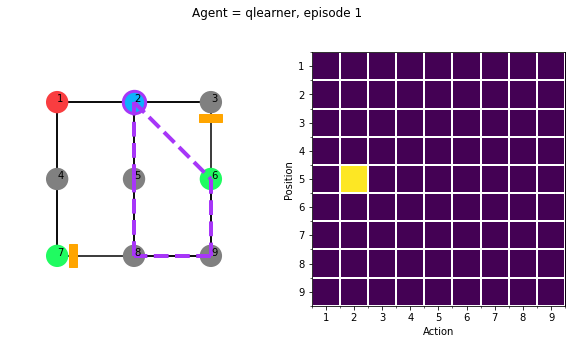

In [ ]:
# Environment set up
level = Environment()
level.setpos(agent=6,exits=[6,7],goal=2)

# Play out level
agent = Agent("qlearner")
play = Play(level,agent,1)